In [1]:
import feather
import pandas as pd
import numpy as np
import pylab as plt
%matplotlib inline

## Look at what files are available

In [2]:
ls HackTimeSeries/

AD1_2002__Kruess_1__12.feather
AD1_2002__Kruess_1__13.feather
AD1_2002__Kruess_1__14.feather
AD1_2002__Kruess_1__15.feather
AD1_2002__Kruess_1__16.feather
AD1_2002__Kruess_1__17.feather
AD1_2002__Kruess_2__12.feather
AD1_2002__Kruess_2__13.feather
AD1_2002__Kruess_2__14.feather
AD1_2002__Kruess_2__15.feather
AD1_2002__Kruess_2__16.feather
AD1_2002__Kruess_2__17.feather
AD1_2002__Kruess_3__13.feather
AD1_2002__Kruess_3__14.feather
AD1_2002__Kruess_3__15.feather
AD1_2002__Kruess_3__16.feather
AD1_2002__Kruess_3__17.feather
AD1_2002__Kruess_3__18.feather
AD1_2008__Kwaiser_1_Milford_2.feather
AD1_2008__Kwaiser_2_Milford_2.feather
AD1_2011__Richards_1__4.feather
AD1_2011__Richards_1__5.feather
AD1_2011__Richards_1__6.feather
AD1_2011__Richards_2__4.feather
AD1_2011__Richards_2__5.feather
AD1_2011__Richards_2__6.feather
AD1_2011__Richards_3__4.feather
AD1_2011__Richards_3__5.feather
AD1_2011__Richards_3__6.feather
CC1_2004__Clark_1_A_1.feather
CC1_2004__Clark_1_A_10.feather
CC1_2004__Clark_1

## Read in an example dataframe

In [3]:

df = feather.read_dataframe('HackTimeSeries/SE2_2014a_Craig_1__10.feather')

In [4]:
df.columns

Index([u'id', u'EVI2', u'NBR', u'NDMI', u'NDVI', u'SS', u'SSBS', u'blue',
       u'green', u'nir', u'red', u'swir1', u'swir2', u'date', u'Sat',
       u'Predominant_habitat', u'Longitude', u'Latitude', u'Biome',
       u'Max_linear_extent', u'Hansenlossyear', u'Sample_start_earliest',
       u'YearsOfConversion'],
      dtype='object')

## Sort by Date and plot

In [5]:
df['Date'] =pd.to_datetime(df.date)

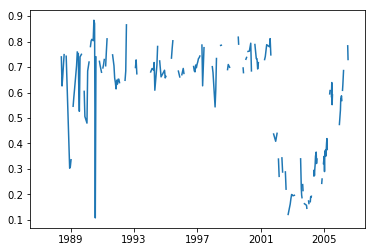

In [6]:
plt.plot(df.sort_values('Date')['Date'],df.sort_values('Date')['NDVI'])

## Convert Datetime to number of days

In [7]:
df['date_delta'] = (df['Date'] - df['Date'].min())  / np.timedelta64(1,'D')

In [81]:
dmin=df['Date'].min()

In [82]:
dmin.year

1986

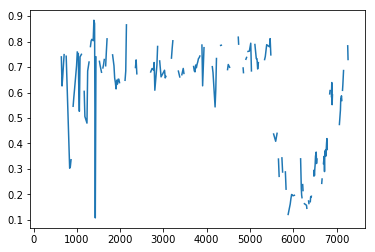

In [8]:
plt.plot(df.sort_values('Date')['date_delta'],df.sort_values('Date')['NDVI'])

## Lets play with GPFlow

In [10]:
import GPflow

Lets use 2 kernels:
1. Perodic exponential Kernel for seasonal variation
2. Squared exponential Kernel for other trend

## First, assign X and Y values by sorting by date, and removing NaNs

In [9]:
X=df.sort_values('Date')['date_delta'].values
Y=df.sort_values('Date')['NDVI'].values
ind_good=np.isfinite(Y)
X=X[ind_good][:,np.newaxis]
Y=Y[ind_good][:,np.newaxis]

In [10]:
k1 = GPflow.kernels.RBF(1)
k2 = GPflow.kernels.PeriodicKernel(1,period=300.0)
m = GPflow.gpr.GPR(X,Y, kern=k1+k2)
m.likelihood.variance = 0.0001

NameError: name 'GPflow' is not defined

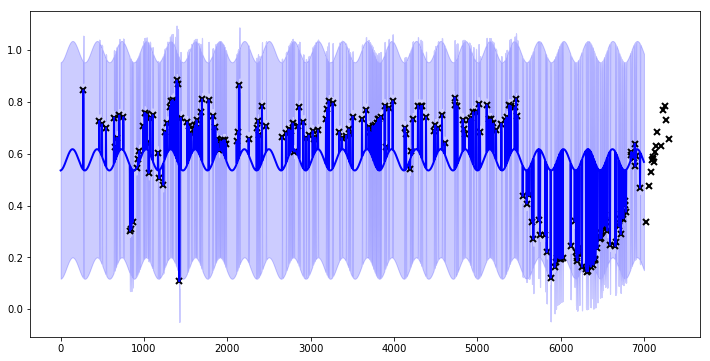

In [141]:
def plot(m):
    xx = np.arange(0, 7000,1,dtype=float)[:,None]
    mean, var = m.predict_y(xx)
    plt.figure(figsize=(12, 6))
    plt.plot(X, Y, 'kx', mew=2)
    plt.plot(xx, mean, 'b', lw=2)
    plt.fill_between(xx[:,0], mean[:,0] - 2*np.sqrt(var[:,0]), mean[:,0] + 2*np.sqrt(var[:,0]), color='blue', alpha=0.2)
plot(m)

Name,values,prior,constraint
name.likelihood.variance,[ 9.91500913e-05],None,+ve
name.kern.periodickernel.variance,[ 0.33557599],None,+ve
name.kern.periodickernel.lengthscales,[ 8.61517903],None,+ve
name.kern.periodickernel.period,[ 294.50707133],None,+ve
name.kern.rbf.lengthscales,[ 0.99999986],None,+ve
name.kern.rbf.variance,[ 0.04307884],None,+ve


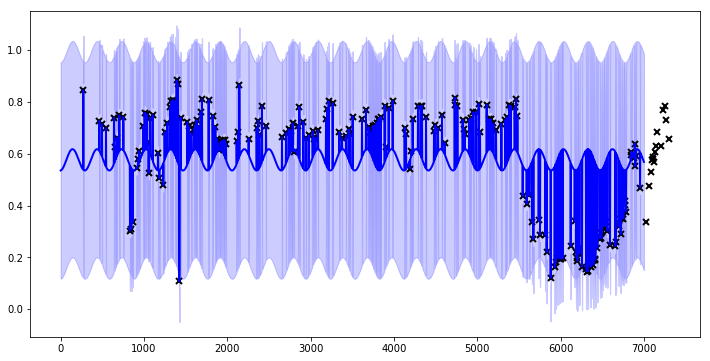

In [142]:
m.optimize(maxiter=10000)
plot(m)
m

## Now I can fit model, use posterior predicitve checks to detect change points

In [143]:
log_pred=np.empty((Y.size))
import scipy.stats as st

for i in range(0,Y.size-1):
    print i
    m = GPflow.gpr.GPR(X[0:i,:],Y[0:i,:], kern=k1+k2)
    m.likelihood.variance = 1.0
    m.optimize(maxiter=10000)
    mean,variance=m.predict_y(X[i+1:i+3,:])
    log_pred[i]=st.norm.ppf(st.norm.cdf(Y[i+1,:], loc=mean, scale=np.sqrt(variance)))[0]


0
1
2
3
4


InvalidArgumentError: Input matrix is not invertible.
	 [[Node: name.build_likelihood/MatrixTriangularSolve = MatrixTriangularSolve[T=DT_DOUBLE, adjoint=false, lower=true, _device="/job:localhost/replica:0/task:0/cpu:0"](name.build_likelihood/Cholesky, name.build_likelihood/sub)]]

Caused by op u'name.build_likelihood/MatrixTriangularSolve', defined at:
  File "/Users/pdh21/anaconda3/envs/old/lib/python2.7/runpy.py", line 174, in _run_module_as_main
    "__main__", fname, loader, pkg_name)
  File "/Users/pdh21/anaconda3/envs/old/lib/python2.7/runpy.py", line 72, in _run_code
    exec code in run_globals
  File "/Users/pdh21/anaconda3/envs/old/lib/python2.7/site-packages/ipykernel_launcher.py", line 16, in <module>
    app.launch_new_instance()
  File "/Users/pdh21/anaconda3/envs/old/lib/python2.7/site-packages/traitlets/config/application.py", line 658, in launch_instance
    app.start()
  File "/Users/pdh21/anaconda3/envs/old/lib/python2.7/site-packages/ipykernel/kernelapp.py", line 477, in start
    ioloop.IOLoop.instance().start()
  File "/Users/pdh21/anaconda3/envs/old/lib/python2.7/site-packages/zmq/eventloop/ioloop.py", line 177, in start
    super(ZMQIOLoop, self).start()
  File "/Users/pdh21/anaconda3/envs/old/lib/python2.7/site-packages/tornado/ioloop.py", line 888, in start
    handler_func(fd_obj, events)
  File "/Users/pdh21/anaconda3/envs/old/lib/python2.7/site-packages/tornado/stack_context.py", line 277, in null_wrapper
    return fn(*args, **kwargs)
  File "/Users/pdh21/anaconda3/envs/old/lib/python2.7/site-packages/zmq/eventloop/zmqstream.py", line 440, in _handle_events
    self._handle_recv()
  File "/Users/pdh21/anaconda3/envs/old/lib/python2.7/site-packages/zmq/eventloop/zmqstream.py", line 472, in _handle_recv
    self._run_callback(callback, msg)
  File "/Users/pdh21/anaconda3/envs/old/lib/python2.7/site-packages/zmq/eventloop/zmqstream.py", line 414, in _run_callback
    callback(*args, **kwargs)
  File "/Users/pdh21/anaconda3/envs/old/lib/python2.7/site-packages/tornado/stack_context.py", line 277, in null_wrapper
    return fn(*args, **kwargs)
  File "/Users/pdh21/anaconda3/envs/old/lib/python2.7/site-packages/ipykernel/kernelbase.py", line 283, in dispatcher
    return self.dispatch_shell(stream, msg)
  File "/Users/pdh21/anaconda3/envs/old/lib/python2.7/site-packages/ipykernel/kernelbase.py", line 235, in dispatch_shell
    handler(stream, idents, msg)
  File "/Users/pdh21/anaconda3/envs/old/lib/python2.7/site-packages/ipykernel/kernelbase.py", line 399, in execute_request
    user_expressions, allow_stdin)
  File "/Users/pdh21/anaconda3/envs/old/lib/python2.7/site-packages/ipykernel/ipkernel.py", line 196, in do_execute
    res = shell.run_cell(code, store_history=store_history, silent=silent)
  File "/Users/pdh21/anaconda3/envs/old/lib/python2.7/site-packages/ipykernel/zmqshell.py", line 533, in run_cell
    return super(ZMQInteractiveShell, self).run_cell(*args, **kwargs)
  File "/Users/pdh21/anaconda3/envs/old/lib/python2.7/site-packages/IPython/core/interactiveshell.py", line 2717, in run_cell
    interactivity=interactivity, compiler=compiler, result=result)
  File "/Users/pdh21/anaconda3/envs/old/lib/python2.7/site-packages/IPython/core/interactiveshell.py", line 2821, in run_ast_nodes
    if self.run_code(code, result):
  File "/Users/pdh21/anaconda3/envs/old/lib/python2.7/site-packages/IPython/core/interactiveshell.py", line 2881, in run_code
    exec(code_obj, self.user_global_ns, self.user_ns)
  File "<ipython-input-143-fe86be55ac7f>", line 8, in <module>
    m.optimize(maxiter=10000)
  File "/Users/pdh21/other_github_repos/GPflow/GPflow/model.py", line 225, in optimize
    return self._optimize_np(method, tol, callback, maxiter, **kw)
  File "/Users/pdh21/other_github_repos/GPflow/GPflow/model.py", line 286, in _optimize_np
    self._compile()
  File "/Users/pdh21/other_github_repos/GPflow/GPflow/model.py", line 135, in _compile
    f = self.build_likelihood() + self.build_prior()
  File "/Users/pdh21/other_github_repos/GPflow/GPflow/scoping.py", line 41, in runnable
    return f(*args, **kwargs)
  File "/Users/pdh21/other_github_repos/GPflow/GPflow/gpr.py", line 63, in build_likelihood
    return multivariate_normal(self.Y, m, L)
  File "/Users/pdh21/other_github_repos/GPflow/GPflow/densities.py", line 81, in multivariate_normal
    alpha = tf.matrix_triangular_solve(L, d, lower=True)
  File "/Users/pdh21/anaconda3/envs/old/lib/python2.7/site-packages/tensorflow/python/ops/gen_linalg_ops.py", line 469, in matrix_triangular_solve
    name=name)
  File "/Users/pdh21/anaconda3/envs/old/lib/python2.7/site-packages/tensorflow/python/framework/op_def_library.py", line 768, in apply_op
    op_def=op_def)
  File "/Users/pdh21/anaconda3/envs/old/lib/python2.7/site-packages/tensorflow/python/framework/ops.py", line 2336, in create_op
    original_op=self._default_original_op, op_def=op_def)
  File "/Users/pdh21/anaconda3/envs/old/lib/python2.7/site-packages/tensorflow/python/framework/ops.py", line 1228, in __init__
    self._traceback = _extract_stack()

InvalidArgumentError (see above for traceback): Input matrix is not invertible.
	 [[Node: name.build_likelihood/MatrixTriangularSolve = MatrixTriangularSolve[T=DT_DOUBLE, adjoint=false, lower=true, _device="/job:localhost/replica:0/task:0/cpu:0"](name.build_likelihood/Cholesky, name.build_likelihood/sub)]]


In [93]:
m.predict_density(X[i+1:i+3],Y[i+1:i+3])

array([[-1.17232831],
       [-1.23473858]])

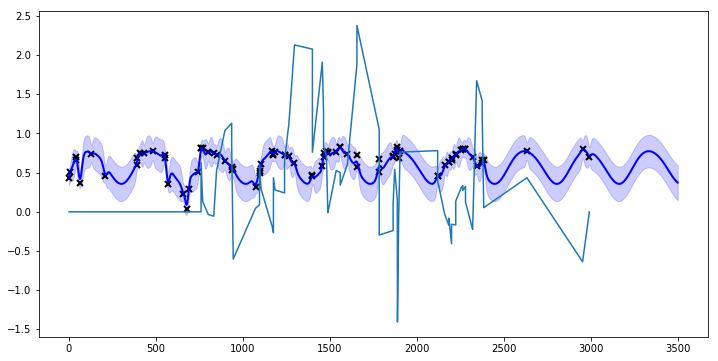

In [26]:
m = GPflow.gpr.GPR(X,Y, kern=k1+k2)
m.likelihood.variance = 0.0001
m.optimize(maxiter=10000)

xx = np.arange(0, 3500,1,dtype=float)[:,None]
mean, var = m.predict_y(xx)
plt.figure(figsize=(12, 6))
plt.plot(X, Y, 'kx', mew=2)
plt.plot(xx, mean, 'b', lw=2)
plt.fill_between(xx[:,0], mean[:,0] - 2*np.sqrt(var[:,0]), mean[:,0] + 2*np.sqrt(var[:,0]), color='blue', alpha=0.2)
plt.plot(X,log_pred)


In [15]:
help(GPflow.kernels.PeriodicKernel)

Help on class PeriodicKernel in module GPflow.kernels:

class PeriodicKernel(Kern)
 |  The periodic kernel. Defined in  Equation (47) of
 |  
 |  D.J.C.MacKay. Introduction to Gaussian processes. In C.M.Bishop, editor,
 |  Neural Networks and Machine Learning, pages 133--165. Springer, 1998.
 |  
 |  Derived using the mapping u=(cos(x), sin(x)) on the inputs.
 |  
 |  Method resolution order:
 |      PeriodicKernel
 |      Kern
 |      GPflow.param.Parameterized
 |      GPflow.param.Parentable
 |      __builtin__.object
 |  
 |  Methods defined here:
 |  
 |  K(self, X, X2=None, presliced=False)
 |  
 |  Kdiag(self, X, presliced=False)
 |  
 |  __init__(self, input_dim, period=1.0, variance=1.0, lengthscales=1.0, active_dims=None)
 |  
 |  ----------------------------------------------------------------------
 |  Methods inherited from Kern:
 |  
 |  __add__(self, other)
 |  
 |  __mul__(self, other)
 |  
 |  compute_K(instance, *np_args)
 |  
 |  compute_K_symm(instance, *np_args)
 | 

## Use GPy

In [10]:
import GPy

In [56]:
k1=GPy.kern.StdPeriodic(input_dim=1)
k1.unconstrain()
#k1.period.set_prior(GPy.priors.Uniform(lower=0.8,upper=1.2))
k1.period.constrain_bounded(0.8,1.2)
#k1.lengthscale.set_prior(GPy.priors.Uniform(lower=0.0,upper=1.0))
k1.lengthscale.constrain_bounded(0,1.0)
#k1.variance.set_prior(GPy.priors.Uniform(lower=0.0,upper=1.0))
k1.variance.fix(1.0)

k2=GPy.kern.RBF(input_dim=1)
k2.unconstrain()
#k2.variance.set_prior(GPy.priors.Uniform(lower=0.0,upper=1.0))
k2.variance.fix(1.0)
#k2.lengthscale.set_prior(GPy.priors.Uniform(lower=2,upper=20))
k2.lengthscale.constrain_bounded(2,20)


k_add = k1+k2

In [57]:
m = GPy.models.GPRegression(X/365.25,Y,k_add)
m.Gaussian_noise.fix(0.05)


array([0])

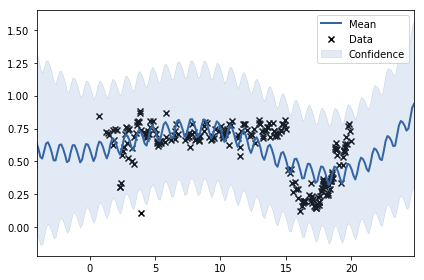

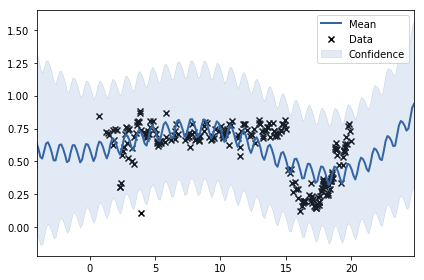

In [58]:
fig = m.plot()
GPy.plotting.show(fig)

In [59]:
m.optimize(messages=True)
m.optimize_restarts(num_restarts=10)

Running L-BFGS-B (Scipy implementation) Code:
  runtime   i      f              |g|        
    00s16  0004  -7.403193e+01   7.575709e+00 
    00s47  0021  -7.812486e+01   1.757754e-09 
Runtime:     00s47
Optimization status: Converged

Optimization restart 1/10, f = -78.1248624829
Optimization restart 2/10, f = -79.5945600721
Optimization restart 3/10, f = -77.789256077
Optimization restart 4/10, f = -78.4922276016
Optimization restart 5/10, f = -78.1494688784
Optimization restart 6/10, f = -77.7892543689
Optimization restart 7/10, f = -78.4922327055
Optimization restart 8/10, f = -81.9966838779
Optimization restart 9/10, f = -77.7892525375
Optimization restart 10/10, f = -78.1248532936


GP_regression.,value,constraints,priors
sum.std_periodic.variance,1.0,fixed,
sum.std_periodic.period,1.00168556025,"0.8,1.2",
sum.std_periodic.lengthscale,0.99999998949,"0.0,1.0",
sum.rbf.variance,1.0,fixed,
sum.rbf.lengthscale,3.83932608674,"2.0,20.0",
Gaussian_noise.variance,0.05,fixed +ve,


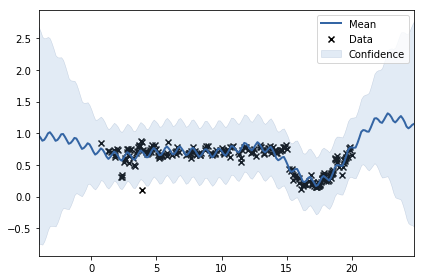

In [60]:
from IPython.display import display
display(m)
fig = m.plot()

In [85]:
log_pred=np.zeros((Y.size))
log_like=np.zeros((Y.size))

import scipy.stats as st

ii=0
xx = np.arange(0, 8000,1,dtype=float)[:,None]
mean_final=np.zeros(8000)[:,None]
variance_final=np.zeros(8000)[:,None]
#for i in range(51,Y.size):
#    m = GPy.models.GPRegression(X[ii:i,:]/365.25,Y[ii:i,:],k1+k3)
#
#    m.optimize()
#    m.optimize_restarts(num_restarts=10,verbose=False)
#    log_like[i]=m.log_likelihood()

#    mean,variance=m.predict(X[i+1:i+2,:]/365.25)
#    log_pred[i]=st.norm.ppf(st.norm.cdf(Y[i+1,:], loc=mean, scale=np.sqrt(variance)))[0]
#    print i,X[i],Y[i],mean[0],variance[0],log_pred[i]

    #if (np.abs(log_pred[i])>3.0) and ((i-ii)>10):
    #    ind=(xx>X[ii]) & (xx<X[i+1])
    #    #print ii,i,xx[ind][:,None].shape,np.abs(log_pred[i])
    #    m_tmp,v_tmp=m.predict(xx[ind][:,None])
    #    #print mean_final[ind].shape,m_tmp
    #    mean_final[ind]=m_tmp[:,0]
    #    variance_final[ind]=v_tmp[:,0]
    #    ii=i
models=[]
changepoints=[]
for i in range(1,Y.size-2):
    m = GPy.models.GPRegression(X[ii:i,:]/365.25,Y[ii:i,:],k1+k2)
    m.Gaussian_noise.fix(0.005)
    m.optimize()
    m.optimize_restarts(num_restarts=2,verbose=False)
    mean,variance=m.predict(X[i+1:i+2,:]/365.25)
    log_pred[i]=st.norm.ppf(st.norm.cdf(Y[i+1,:], loc=mean, scale=np.sqrt(variance)))[0]
    print i,X[i],Y[i],mean[0],variance[0],log_pred[i]
    if (np.abs(log_pred[i])>3.0) or (i==Y.size-2): #((i-ii)>22)
        ind=(xx>X[ii]) & (xx<X[i+1])
        print ii,i,xx[ind][:,None].shape,np.abs(log_pred[i])
        m_tmp,v_tmp=m.predict(xx[ind][:,None]/365.25)
        #print mean_final[ind].shape,m_tmp
        mean_final[ind]=m_tmp[:,0]
        variance_final[ind]=v_tmp[:,0]
        models.append(m)
        changepoints.append(i)
        ii=i
        
i=Y.size-2
ind=(xx>X[ii])
m_tmp,v_tmp=m.predict(xx[ind][:,None]/365.25)
#print mean_final[ind].shape,m_tmp
mean_final[ind]=m_tmp[:,0]
variance_final[ind]=v_tmp[:,0]
models.append(m)

1 [ 464.] [ 0.72722367] [ 0.69343353] [ 0.65875409] 0.0258134352661
2 [ 496.] [ 0.71438466] [ 0.83718567] [ 0.04151602] -0.673149081439
3 [ 544.] [ 0.70002831] [ 0.79633836] [ 0.12556626] -0.159239482338
4 [ 640.] [ 0.73991132] [ 0.89767406] [ 0.29530768] -0.500427667734
5 [ 656.] [ 0.62573056] [ 0.84905349] [ 0.02931678] -1.08705204318
6 [ 672.] [ 0.66292688] [ 0.45219219] [ 0.05934229] 1.21764143848
7 [ 704.] [ 0.74881296] [ 0.65524421] [ 0.0588593] 0.359474221064
8 [ 752.] [ 0.74245602] [ 0.68349795] [ 0.00995181] -3.81911226949
0 8 (559, 1) 3.81911226949
9 [ 832.] [ 0.30250798] [ 0.65283891] [ 0.45480984] -0.509800601892
10 [ 848.] [ 0.30903148] [ 0.19208279] [ 0.04618697] 0.66872185705
11 [ 864.] [ 0.33579882] [ 0.32495796] [ 0.14546748] 0.579429582397
12 [ 912.] [ 0.54595356] [ 0.50964591] [ 0.11006734] 0.212793833895
13 [ 928.] [ 0.58024324] [ 0.70149629] [ 0.03016526] -0.523229429288
14 [ 944.] [ 0.61062101] [ 0.80528403] [ 0.09934637] -0.315284786053
15 [ 992.] [ 0.7059086] [ 

119 [ 4608.] [ 0.64142048] [ 0.76201641] [ 0.00618568] 0.703626771353
120 [ 4728.] [ 0.817356] [ 0.73683395] [ 0.00618424] 0.676327084566
121 [ 4736.] [ 0.79002029] [ 0.71893002] [ 0.00615626] 0.828781466262
122 [ 4760.] [ 0.78395774] [ 0.68027733] [ 0.0060508] 0.6579236555
123 [ 4824.] [ 0.73145516] [ 0.68697866] [ 0.00592476] 0.121628098056
124 [ 4840.] [ 0.69634068] [ 0.69606271] [ 0.00576911] -0.237048952301
125 [ 4848.] [ 0.67805773] [ 0.70422076] [ 0.00591223] 0.344120954267
126 [ 4904.] [ 0.73068057] [ 0.70701568] [ 0.00589383] 0.402193751141
127 [ 4920.] [ 0.73789262] [ 0.71761921] [ 0.00589151] 0.569006849025
128 [ 4952.] [ 0.761294] [ 0.72253938] [ 0.00608357] 0.514105860542
129 [ 4984.] [ 0.76263822] [ 0.75196581] [ 0.00608801] 0.535170934117
130 [ 5016.] [ 0.79372288] [ 0.7781169] [ 0.00599433] -1.20416958651
131 [ 5032.] [ 0.68488639] [ 0.77217055] [ 0.00590754] 0.213628231642
132 [ 5112.] [ 0.78859013] [ 0.73315016] [ 0.00605876] -0.00437497827358
133 [ 5144.] [ 0.7328096

In [21]:
print X

[[  272.]
 [  464.]
 [  496.]
 [  544.]
 [  640.]
 [  656.]
 [  672.]
 [  704.]
 [  752.]
 [  832.]
 [  848.]
 [  864.]
 [  912.]
 [  928.]
 [  944.]
 [  992.]
 [ 1008.]
 [ 1032.]
 [ 1040.]
 [ 1056.]
 [ 1072.]
 [ 1104.]
 [ 1168.]
 [ 1184.]
 [ 1232.]
 [ 1248.]
 [ 1280.]
 [ 1312.]
 [ 1328.]
 [ 1344.]
 [ 1376.]
 [ 1392.]
 [ 1408.]
 [ 1424.]
 [ 1440.]
 [ 1520.]
 [ 1536.]
 [ 1568.]
 [ 1600.]
 [ 1616.]
 [ 1632.]
 [ 1664.]
 [ 1680.]
 [ 1696.]
 [ 1776.]
 [ 1824.]
 [ 1856.]
 [ 1872.]
 [ 1888.]
 [ 1904.]
 [ 1920.]
 [ 1936.]
 [ 1952.]
 [ 1968.]
 [ 1984.]
 [ 2112.]
 [ 2128.]
 [ 2144.]
 [ 2256.]
 [ 2352.]
 [ 2368.]
 [ 2384.]
 [ 2416.]
 [ 2464.]
 [ 2656.]
 [ 2704.]
 [ 2736.]
 [ 2752.]
 [ 2768.]
 [ 2784.]
 [ 2800.]
 [ 2848.]
 [ 2864.]
 [ 2912.]
 [ 2944.]
 [ 2976.]
 [ 3024.]
 [ 3040.]
 [ 3056.]
 [ 3088.]
 [ 3184.]
 [ 3200.]
 [ 3216.]
 [ 3264.]
 [ 3344.]
 [ 3376.]
 [ 3424.]
 [ 3456.]
 [ 3472.]
 [ 3504.]
 [ 3616.]
 [ 3664.]
 [ 3696.]
 [ 3712.]
 [ 3728.]
 [ 3744.]
 [ 3760.]
 [ 3776.]
 [ 3792.]
 [ 3808.]


In [20]:
print m.log_likelihood()

115.067223958


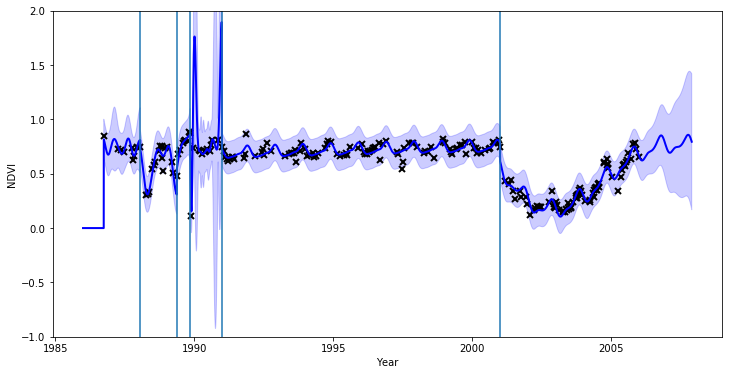

In [90]:
xx = np.arange(0, 8000,1,dtype=float)[:,None]

plt.figure(figsize=(12, 6))
plt.plot(dmin.year+X/365.25, Y, 'kx', mew=2)
plt.plot(dmin.year+xx/365.25, mean_final, 'b', lw=2)
plt.fill_between(dmin.year+xx[:,0]/365.25, mean_final[:,0] - 2*np.sqrt(variance_final[:,0]), mean_final[:,0] + 2*np.sqrt(variance_final[:,0]), color='blue', alpha=0.2)
#for i in range(0,log_pred.size):
#    plt.plot(dmin.year+X[i]/365.25,Y[i], 'ro', markersize=log_pred[i], alpha=0.2)
#plt.plot(dmin.year+X[np.abs(log_pred)>3.0]/365.25,Y[np.abs(log_pred)>3.0],'ro')
plt.ylim(-1,2)
plt.ylabel('NDVI')
plt.xlabel('Year')
for c in changepoints:
    plt.axvline(x=dmin.year+X[c]/365.25)

(-8, 8)

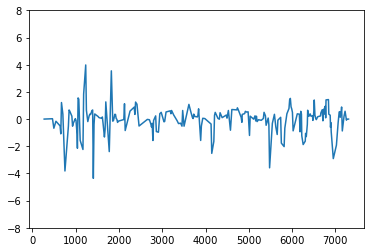

In [76]:
plt.plot(X,log_pred)

plt.ylim(-8,8)

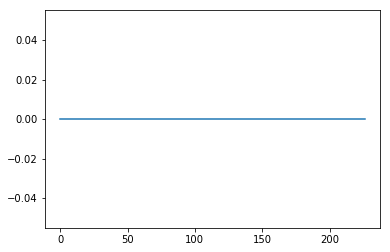

In [44]:
plt.plot(np.arange(0,log_like.size),log_like)


In [45]:
help(m.log_likelihood)

Help on method log_likelihood in module GPy.core.gp:

log_likelihood(self) method of GPy.models.gp_regression.GPRegression instance
    The log marginal likelihood of the model, :math:`p(\mathbf{y})`, this is the objective function of the model being optimised



In [75]:
from IPython.display import display
for m in models:
    display(m)

GP_regression.,value,constraints,priors
sum.std_periodic.variance,1.0,fixed,
sum.std_periodic.period,0.927455927504,"0.8,1.2",
sum.std_periodic.lengthscale,0.9999999999,"0.0,1.0",
sum.rbf.variance,1.0,fixed,
sum.rbf.lengthscale,19.9999858476,"2.0,20.0",
Gaussian_noise.variance,0.005,fixed +ve,


GP_regression.,value,constraints,priors
sum.std_periodic.variance,1.0,fixed,
sum.std_periodic.period,1.07190007262,"0.8,1.2",
sum.std_periodic.lengthscale,0.9999999999,"0.0,1.0",
sum.rbf.variance,1.0,fixed,
sum.rbf.lengthscale,19.9999304568,"2.0,20.0",
Gaussian_noise.variance,0.005,fixed +ve,


GP_regression.,value,constraints,priors
sum.std_periodic.variance,1.0,fixed,
sum.std_periodic.period,1.1999967045,"0.8,1.2",
sum.std_periodic.lengthscale,0.9999999999,"0.0,1.0",
sum.rbf.variance,1.0,fixed,
sum.rbf.lengthscale,9.75219125763,"2.0,20.0",
Gaussian_noise.variance,0.005,fixed +ve,


GP_regression.,value,constraints,priors
sum.std_periodic.variance,1.0,fixed,
sum.std_periodic.period,1.19999984156,"0.8,1.2",
sum.std_periodic.lengthscale,0.191082888041,"0.0,1.0",
sum.rbf.variance,1.0,fixed,
sum.rbf.lengthscale,19.9718100701,"2.0,20.0",
Gaussian_noise.variance,0.005,fixed +ve,


GP_regression.,value,constraints,priors
sum.std_periodic.variance,1.0,fixed,
sum.std_periodic.period,0.999839368778,"0.8,1.2",
sum.std_periodic.lengthscale,0.9999999999,"0.0,1.0",
sum.rbf.variance,1.0,fixed,
sum.rbf.lengthscale,19.9999515561,"2.0,20.0",
Gaussian_noise.variance,0.005,fixed +ve,


GP_regression.,value,constraints,priors
sum.std_periodic.variance,1.0,fixed,
sum.std_periodic.period,0.982342706302,"0.8,1.2",
sum.std_periodic.lengthscale,0.9999999999,"0.0,1.0",
sum.rbf.variance,1.0,fixed,
sum.rbf.lengthscale,3.23336645148,"2.0,20.0",
Gaussian_noise.variance,0.005,fixed +ve,
